In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import *
import tensorflow.keras.backend as K

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=False):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return pd.DataFrame(agg.astype('float32'))

In [3]:
def train_valid_test_split(data, hours_of_history, hours_to_predict, parameters_included):
  y_list = list(range(parameters_included*hours_of_history+parameters_included-1, parameters_included*(hours_of_history+hours_to_predict)+parameters_included-1, parameters_included))
  all_list = list(range(0, parameters_included*(hours_of_history+hours_to_predict)))
  x_list = [item for item in all_list if item not in y_list]

  data_train = data.iloc[:52608,:] # the first 6 years for training/validation
  data_test = data.iloc[52608:,:] # the last 1 years for test evaluation
  data_train.dropna(inplace=True)
  data_test.dropna(inplace=True)

  x_train_valid = data_train.iloc[:,x_list].values
  x_test = data_test.iloc[:,x_list].values
  y_train_valid = data_train.iloc[:,y_list].values
  y_test = data_test.iloc[:,y_list].values

  x_valid, x_train, y_valid, y_train = train_test_split(x_train_valid, y_train_valid, test_size=0.4, shuffle= False) # the first 60% data in the first 6 years used for training and the rest 40% used for validation.

  return x_train, x_valid, x_test, y_train, y_valid, y_test

In [4]:
def prepare_data(station_id, hours_of_history, hours_to_predict, parameters_included):
  # load the data
  data = pd.read_csv('./data/'+str(station_id)+'_data.csv').iloc[:,1:]

  # simple min-max scaling. Other pretreatments such as normalization also work.
  scaler = MinMaxScaler()
  scaler.fit(data.iloc[:52608,:]) # min-max scaling without the test dataset.
  q_max = np.max(data.iloc[:52608,2]) # manually check the maximum and minimum discharge
  q_min = np.min(data.iloc[:52608,2])
  data_scaled = scaler.transform(data)

  # data split
  data_sequence = series_to_supervised(data_scaled, hours_of_history, hours_to_predict)
  x_train, x_valid, x_test, y_train, y_valid, y_test = train_valid_test_split(data_sequence, hours_of_history, hours_to_predict, parameters_included)

  # Split data into 2 parts for encoder (history) and decoder(future).
  x_train_encoder = x_train[:,:hours_of_history*parameters_included].reshape(-1, hours_of_history, parameters_included)
  x_train_decoder = x_train[:,hours_of_history*parameters_included:].reshape(-1, hours_to_predict, parameters_included-1)
  x_valid_encoder = x_valid[:,:hours_of_history*parameters_included].reshape(-1, hours_of_history, parameters_included)
  x_valid_decoder = x_valid[:,hours_of_history*parameters_included:].reshape(-1, hours_to_predict, parameters_included-1)
  x_test_encoder = x_test[:,:hours_of_history*parameters_included].reshape(-1, hours_of_history, parameters_included)
  x_test_decoder = x_test[:,hours_of_history*parameters_included:].reshape(-1, hours_to_predict, parameters_included-1)

  return x_train_encoder, x_train_decoder, x_valid_encoder, x_valid_decoder, x_test_encoder, x_test_decoder, y_train, y_valid, y_test, q_max, q_min

In [5]:
# define custome loss function (you can use the simple 'mse' as well)
def nseloss(y_true, y_pred):
  return K.sum((y_pred-y_true)**2)/K.sum((y_true-K.mean(y_true))**2)

In [6]:
def NRM(hours_of_history, hours_to_predict, parameters_included):
  
  # design network
  dim_dense = [128, 64, 64, 32, 32]
  drop = 0.2

  encoder_input = Input(shape=(hours_of_history,parameters_included))
  encoder_GRU1 = GRU(32, return_state=True, return_sequences=True)
  encoder_output1, encoder_hc1 = encoder_GRU1(encoder_input)
  encoder_GRU2 = GRU(32, return_state=True, return_sequences=True)
  encoder_output2, encoder_hc2 = encoder_GRU2(encoder_output1)
  encoder_GRU3 = GRU(32, return_state=True, return_sequences=True)
  encoder_output3, encoder_hc3 = encoder_GRU3(encoder_output2)
  encoder_GRU4 = GRU(32, return_state=True, return_sequences=True)
  encoder_output4, encoder_hc4 = encoder_GRU4(encoder_output3)
  encoder_GRU5 = GRU(32, return_state=True)
  encoder_output5, encoder_hc5 = encoder_GRU5(encoder_output4)

  decoder_input = Input(shape=(hours_to_predict,parameters_included-1))
  decoder_GRU1 = GRU(32, return_sequences=True)
  decoder_GRU2 = GRU(32, return_sequences=True)
  decoder_GRU3 = GRU(32, return_sequences=True)
  decoder_GRU4 = GRU(32, return_sequences=True)
  decoder_GRU5 = GRU(32, return_sequences=True)
  x = decoder_GRU1(decoder_input, initial_state=encoder_hc1)
  x = decoder_GRU2(x, initial_state=encoder_hc2)
  x = decoder_GRU3(x, initial_state=encoder_hc3)
  x = decoder_GRU4(x, initial_state=encoder_hc4)
  x = decoder_GRU5(x, initial_state=encoder_hc5)

  for dim in dim_dense:
    x = TimeDistributed(Dense(dim, activation='tanh'))(x) # or relu
    x = TimeDistributed(Dropout(drop))(x)
  main_out = TimeDistributed(Dense(1, activation='linear'))(x) # relu as the last activation works (only) for the min-max scalling so there is no negative output
  main_out = Flatten()(main_out)
  model = Model(inputs=[encoder_input, decoder_input], outputs=main_out)
  return model

In [7]:
# identify KGE, NSE for evaluation
def nse(y_true, y_pred):
  return 1-np.sum((y_pred-y_true)**2)/np.sum((y_true-np.mean(y_true))**2)
  
def kge(y_true, y_pred):
  kge_r = np.corrcoef(y_true,y_pred)[1][0]
  kge_a = np.std(y_pred)/np.std(y_true)
  kge_b = np.mean(y_pred)/np.mean(y_true)
  return 1-np.sqrt((kge_r-1)**2+(kge_a-1)**2+(kge_b-1)**2)


In [ ]:
def main():
  # parameters
  station_id = 521
  hours_to_predict = 120
  hours_of_history = 72
  parameters_included = 3

  batch_size = 64
  lr = 0.0001
  epochs = 300
  test_name = './'+str(station_id)+'_model2_'

  # load data
  x_train_encoder, x_train_decoder, x_valid_encoder, x_valid_decoder, x_test_encoder, x_test_decoder, y_train, y_valid, y_test, q_max, q_min = prepare_data(station_id, hours_of_history, hours_to_predict, parameters_included)
  model2 = NRM(hours_of_history, hours_to_predict, parameters_included)

  # compile settings
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, cooldown=200, min_lr=1e-8)
  earlystoping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')
  checkpoint = ModelCheckpoint(test_name+'model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
  optimizer = RMSprop(learning_rate=lr)  # optimizer = RMSprop(lr=lr)
  model2.compile(optimizer=optimizer, loss=nseloss) # in paper, we used the customized "nseloss" as model 1 did. however, here we show mse as an example.

  # train model
  history = model2.fit([x_train_encoder, x_train_decoder], y_train, epochs=epochs, batch_size=batch_size,
              validation_data=([x_valid_encoder, x_valid_decoder], y_valid), callbacks=[reduce_lr, earlystoping, checkpoint], verbose=1)

  # save training loss
  loss_train = history.history['loss']
  loss_valid = history.history['val_loss']
  loss_train = pd.DataFrame({'TrainLoss':loss_train})
  loss_valid = pd.DataFrame({'TestLoss':loss_valid})
  LossEpoches = pd.concat([loss_train, loss_valid], axis=1)
  LossEpoches.to_csv(test_name+'loss.csv', index = True)

  # Final Test Review
  model2.load_weights(test_name+'model.h5')

  y_model_scaled = model2.predict([x_test_encoder,x_test_decoder])
  y_model = y_model_scaled*(q_max-q_min)+q_min
  y_test = y_test*(q_max-q_min)+q_min

  # hourly evaluation
  NSEs=[]
  KGEs=[]
  for x in range(0, 120):
    y_pred = y_model[:,x]
    y_True = y_test[:,x]
    NSEs.append(nse(y_True,y_pred))
    KGEs.append(kge(y_True,y_pred))
    
  NSEs=pd.DataFrame(NSEs)
  NSEs.columns = ['NSE_Test']
  KGEs=pd.DataFrame(KGEs)
  KGEs.columns = ['KGE_Test']
    
  eva = pd.concat([NSEs, KGEs], axis=1)
  eva.to_csv(test_name+'eva.csv', index = True)


In [11]:
if __name__ == "__main__":
  main()


C:\Users\hdagne1\AppData\Local\Temp\ipykernel_12216\3261867468.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train.dropna(inplace=True)
C:\Users\hdagne1\AppData\Local\Temp\ipykernel_12216\3261867468.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.dropna(inplace=True)


Epoch 1/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - loss: 1.2263
Epoch 1: val_loss improved from inf to 4077.56909, saving model to ./521_model2_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 236s 507ms/step - loss: 1.2257 - val_loss: 4077.5691 - learning_rate: 1.0000e-04
Epoch 2/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 0.9081
Epoch 2: val_loss did not improve from 4077.56909
274/274 ━━━━━━━━━━━━━━━━━━━━ 118s 432ms/step - loss: 0.9081 - val_loss: 7400.2109 - learning_rate: 1.0000e-04
Epoch 3/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - loss: 0.8391
Epoch 3: val_loss did not improve from 4077.56909
274/274 ━━━━━━━━━━━━━━━━━━━━ 119s 436ms/step - loss: 0.8391 - val_loss: 4257.4600 - learning_rate: 1.0000e-04
Epoch 4/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 0.7852
Epoch 4: val_loss improved from 4077.56909 to 2037.72449, saving model to ./521_model2_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 118s 429ms/step - loss: 0.7853 - val_loss: 2037.7245 - learning_rate: 1.0000e-04
Epoch 5/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - loss: 0.7856
Epoch 5: val_loss did not improve from 2037.72449
274/274 ━━━━━━━━━━━━━━━━━━━━ 120s 436ms/step - loss: 0.7855 - val_loss: 20874.9980 - learning_rate: 1.0000e-04
Epoch 6/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - loss: 0.7275
Epoch 6: val_loss did not improve from 2037.72449
274/274 ━━━━━━━━━━━━━━━━━━━━ 122s 446ms/step - loss: 0.7275 - val_loss: 6844.6899 - learning_rate: 1.0000e-04
Epoch 7/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - loss: 0.7197
Epoch 7: val_loss did not improve from 2037.72449
274/274 ━━━━━━━━━━━━━━━━━━━━ 122s 447ms/step - loss: 0.7197 - val_loss: 4536.1362 - learning_rate: 1.0000e-04
Epoch 8/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - loss: 0.6874
Epoch 8: val_loss did not improve from 2037.72449
274/274 ━━━━━━━━━━━━━━━━━━━━ 121s 443ms/step - loss: 0.6874 - val_loss: 20515.2

274/274 ━━━━━━━━━━━━━━━━━━━━ 123s 450ms/step - loss: 0.4781 - val_loss: 382.4584 - learning_rate: 1.0000e-04
Epoch 15/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - loss: 0.4631
Epoch 15: val_loss did not improve from 382.45840
274/274 ━━━━━━━━━━━━━━━━━━━━ 124s 454ms/step - loss: 0.4630 - val_loss: 14260.6934 - learning_rate: 1.0000e-04
Epoch 16/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - loss: 0.3880
Epoch 16: val_loss did not improve from 382.45840
274/274 ━━━━━━━━━━━━━━━━━━━━ 123s 450ms/step - loss: 0.3879 - val_loss: 1680.4550 - learning_rate: 1.0000e-04
Epoch 17/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - loss: 0.3342
Epoch 17: val_loss did not improve from 382.45840
274/274 ━━━━━━━━━━━━━━━━━━━━ 123s 448ms/step - loss: 0.3341 - val_loss: 2450.3008 - learning_rate: 1.0000e-04
Epoch 18/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - loss: 0.2837
Epoch 18: val_loss did not improve from 382.45840
274/274 ━━━━━━━━━━━━━━━━━━━━ 122s 447ms/step - loss: 0.2837 - val_loss: 1719

274/274 ━━━━━━━━━━━━━━━━━━━━ 121s 440ms/step - loss: 0.2752 - val_loss: 202.3996 - learning_rate: 1.0000e-04
Epoch 20/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - loss: 0.2557
Epoch 20: val_loss did not improve from 202.39964
274/274 ━━━━━━━━━━━━━━━━━━━━ 121s 443ms/step - loss: 0.2557 - val_loss: 1661.2587 - learning_rate: 1.0000e-04
Epoch 21/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 0.2357
Epoch 21: val_loss did not improve from 202.39964
274/274 ━━━━━━━━━━━━━━━━━━━━ 120s 438ms/step - loss: 0.2357 - val_loss: 338.4499 - learning_rate: 1.0000e-04
Epoch 22/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - loss: 0.2374
Epoch 22: val_loss did not improve from 202.39964
274/274 ━━━━━━━━━━━━━━━━━━━━ 144s 445ms/step - loss: 0.2375 - val_loss: 351.2870 - learning_rate: 1.0000e-04
Epoch 23/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - loss: 0.2415
Epoch 23: val_loss improved from 202.39964 to 133.52248, saving model to ./521_model2_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 121s 441ms/step - loss: 0.2415 - val_loss: 133.5225 - learning_rate: 1.0000e-04
Epoch 24/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - loss: 0.2212
Epoch 24: val_loss improved from 133.52248 to 132.94646, saving model to ./521_model2_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 122s 444ms/step - loss: 0.2212 - val_loss: 132.9465 - learning_rate: 1.0000e-04
Epoch 25/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - loss: 0.2250
Epoch 25: val_loss did not improve from 132.94646
274/274 ━━━━━━━━━━━━━━━━━━━━ 122s 444ms/step - loss: 0.2250 - val_loss: 291.5650 - learning_rate: 1.0000e-04
Epoch 26/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - loss: 0.2315
Epoch 26: val_loss did not improve from 132.94646
274/274 ━━━━━━━━━━━━━━━━━━━━ 120s 439ms/step - loss: 0.2315 - val_loss: 1013.3096 - learning_rate: 1.0000e-04
Epoch 27/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - loss: 0.2239
Epoch 27: val_loss did not improve from 132.94646
274/274 ━━━━━━━━━━━━━━━━━━━━ 120s 437ms/step - loss: 0.2239 - val_loss: 716.8336 - learning_rate: 1.0000e-04
Epoch 28/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 0.2096
Epoch 28: val_loss did not improve from 132.94646
274/274 ━━━━━━━━━━━━━━━━━━━━ 120s 438ms/step - loss: 0.2097 - val_loss: 613.724

274/274 ━━━━━━━━━━━━━━━━━━━━ 94s 343ms/step - loss: 0.1613 - val_loss: 95.5664 - learning_rate: 2.0000e-05
Epoch 38/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.1598
Epoch 38: val_loss did not improve from 95.56638
274/274 ━━━━━━━━━━━━━━━━━━━━ 80s 292ms/step - loss: 0.1598 - val_loss: 106.3310 - learning_rate: 2.0000e-05
Epoch 39/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.1514
Epoch 39: val_loss did not improve from 95.56638
274/274 ━━━━━━━━━━━━━━━━━━━━ 79s 289ms/step - loss: 0.1514 - val_loss: 102.7021 - learning_rate: 2.0000e-05
Epoch 40/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.1627
Epoch 40: val_loss improved from 95.56638 to 64.30164, saving model to ./521_model2_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 79s 290ms/step - loss: 0.1627 - val_loss: 64.3016 - learning_rate: 2.0000e-05
Epoch 41/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.1556
Epoch 41: val_loss did not improve from 64.30164
274/274 ━━━━━━━━━━━━━━━━━━━━ 80s 293ms/step - loss: 0.1556 - val_loss: 311.1048 - learning_rate: 2.0000e-05
Epoch 42/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.1536
Epoch 42: val_loss did not improve from 64.30164
274/274 ━━━━━━━━━━━━━━━━━━━━ 79s 290ms/step - loss: 0.1537 - val_loss: 409.7253 - learning_rate: 2.0000e-05
Epoch 43/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.1519
Epoch 43: val_loss did not improve from 64.30164
274/274 ━━━━━━━━━━━━━━━━━━━━ 80s 290ms/step - loss: 0.1520 - val_loss: 330.3179 - learning_rate: 2.0000e-05
Epoch 44/300
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.1552
Epoch 44: val_loss did not improve from 64.30164
274/274 ━━━━━━━━━━━━━━━━━━━━ 79s 290ms/step - loss: 0.1552 - val_loss: 110.8824 - learnin

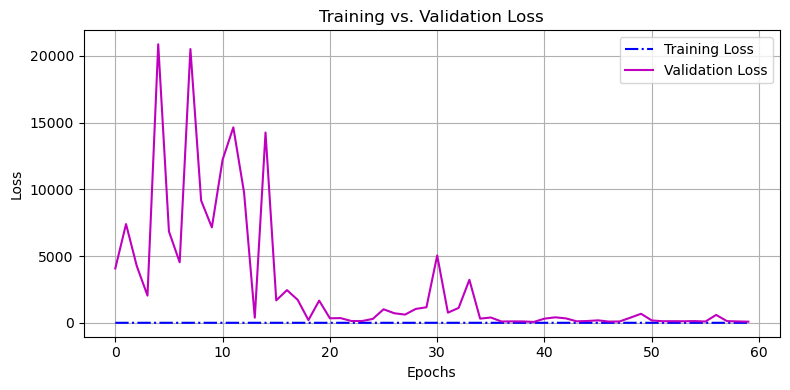

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

loss_df = pd.read_csv('521_model2_loss.csv')

plt.figure(figsize=(8, 4))
plt.plot(loss_df['TrainLoss'], label='Training Loss', color='blue', linestyle='-.')
plt.plot(loss_df['TestLoss'], label='Validation Loss', color='m')
plt.xlabel('Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


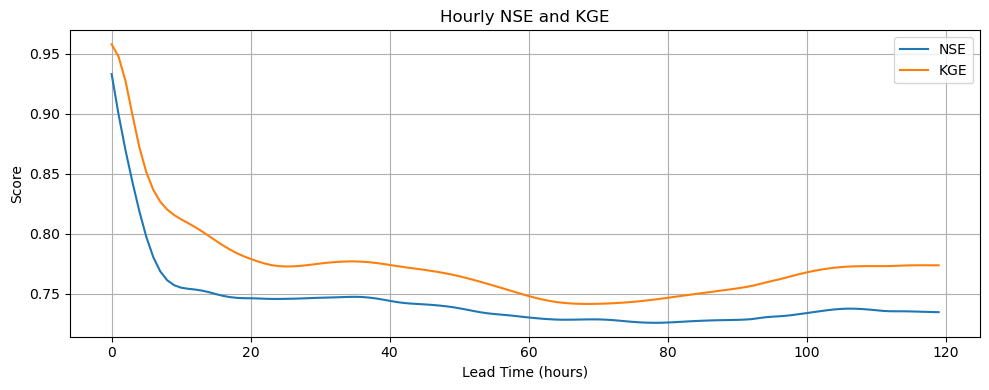

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
eva_df = pd.read_csv('521_model2_eva.csv')

plt.figure(figsize=(10, 4))
plt.plot(eva_df['NSE_Test'], label='NSE')
plt.plot(eva_df['KGE_Test'], label='KGE')
plt.xlabel('Lead Time (hours)')
plt.ylabel('Score')
plt.title('Hourly NSE and KGE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
